### Flatiron School DS January 2019 Hackathon <a id='top'></a>
* Emily J. Cain & Andrew Wester
* Sunday, January 27, 2019

### I. <a href='#section_1'>Load & Inspect the Data</a>
### II. <a href='#section_2'>Data Cleaning & Exploratory Data Analysis</a>
* <a href='#hidden_values'>Hidden Values</a>
* <a href='#convert_binary'>Convert Binary Columns</a>
* <a href='#corr_heatmap'>Correlation Heatmap</a>

### III. <a href='#section_3'>Preprocess the Data</a>
### IV. <a href='#section_4'>Modeling</a>
* Custom Functions
 * <a href='#print_metrics'>Print Metrics Function</a> 
 * <a href='#custom_predict'>Custom Prediction Function</a>
 * <a href='#plot_features'>Plot Feature Importance Function</a>
* <a href='#gridsearch'>GridSearch</a>
 * <a href='#random_forest'>Random Forest</a>
 * <a href='#decision_tree'>Decision Tree</a>
 * <a href='#ada_boost'>AdaBoost</a>
 * <a href='#gradient'>Gradient Boosting</a>

### V. <a href='#section_5'>Conclusions & Recommendations</a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score
from sklearn.metrics import make_scorer, recall_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

### I. Load & Inspect the Data <a id='section_1'></a>
<a href='#top'>Back to Top</a>

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [4]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

#### Class imbalance may indicate the need for weighting in the modeling phase

In [6]:
# check for placeholder values
# for col in df.columns:
    # print(df[col].value_counts().nlargest(10))

### II. Data Cleaning & Exploratory Data Analysis <a id='section_2'></a>
<a href='#top'>Back to Top</a>

In [6]:
df.TotalCharges.value_counts().nlargest(5)

         11
20.2     11
19.75     9
19.65     8
19.9      8
Name: TotalCharges, dtype: int64

#### We were unable to convert the TotalCharges column from string values to floats with the hidden values present. To find the 11 hidden values, we examined the CSV file to identify them by customerID <a id='hidden_values'></a>

In [7]:
hidden_vals = ['4472-LVYGI', '3115-CZMZD', '5709-LVOEQ', '4367-NUYAO', '1371-DWPAZ', '7644-OMVMY', 
               '3213-VVOLG', '2520-SGTTA', '2923-ARZLG', '4075-WKNIU', '2775-SEFEE']

In [8]:
for val in hidden_vals:
    print(df.loc[df['customerID'] == val].index)

Int64Index([488], dtype='int64')
Int64Index([753], dtype='int64')
Int64Index([936], dtype='int64')
Int64Index([1082], dtype='int64')
Int64Index([1340], dtype='int64')
Int64Index([3331], dtype='int64')
Int64Index([3826], dtype='int64')
Int64Index([4380], dtype='int64')
Int64Index([5218], dtype='int64')
Int64Index([6670], dtype='int64')
Int64Index([6754], dtype='int64')


In [9]:
indices = [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]
for index in indices:
    df.drop(index=index, inplace=True)

In [10]:
# confirm that there are no longer any hidden values in TotalCharges column
df.TotalCharges.value_counts().nlargest(5)

20.2     11
19.75     9
19.9      8
20.05     8
19.65     8
Name: TotalCharges, dtype: int64

In [11]:
df.TotalCharges = df.TotalCharges.astype('float')

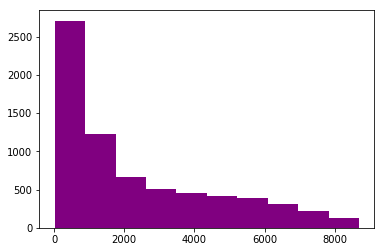

In [20]:
plt.hist(df.TotalCharges, color='purple');

In [12]:
df.drop('customerID', inplace=True, axis=1)

In [13]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Convert binary columns <a id='convert_binary'></a>
<a href='#top'>Back to Top</a>

In [14]:
yes_no_columns = ['Partner',
                  'Dependents',
                  'PhoneService',
                  'OnlineSecurity',
                  'OnlineBackup',
                  'DeviceProtection',
                  'TechSupport',
                  'StreamingMovies',
                  'StreamingTV',
                  'PaperlessBilling',
                  'Churn'
                 ]

for col in yes_no_columns:
    df[col].replace(to_replace='Yes', value=1, inplace=True)
    df[col].replace(to_replace='No', value=0, inplace=True)

In [15]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No phone service,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No phone service,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [16]:
df.gender.replace({'Female': 1, 'Male': 0}, inplace=True)

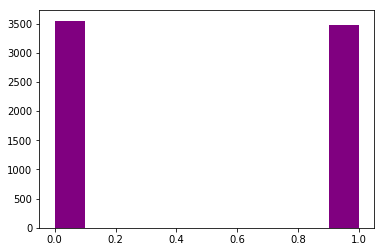

In [25]:
plt.hist(df.gender, color='purple');

In [17]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,No phone service,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,No,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,1,No,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,No phone service,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,1,0,0,0,2,1,No,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


#### Drop the MultipleLines column, which provides some redundant but less precise information than the PhoneService column

In [18]:
df.drop('MultipleLines', axis=1, inplace=True)

In [19]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,1,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,1,0,0,0,2,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [21]:
df.corr()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
gender,1.000000,0.001819,0.001379,-0.010349,-0.005285,0.007515,0.011902,0.013779,-0.000048,0.008545
SeniorCitizen,0.001819,1.000000,0.016957,-0.210550,0.015683,0.008392,0.156258,0.219874,0.102411,0.150541
Partner,0.001379,0.016957,1.000000,0.452269,0.381912,0.018397,-0.013957,0.097825,0.319072,-0.149982
Dependents,-0.010349,-0.210550,0.452269,1.000000,0.163386,-0.001078,-0.110131,-0.112343,0.064653,-0.163128
tenure,-0.005285,0.015683,0.381912,0.163386,1.000000,0.007877,0.004823,0.246862,0.825880,-0.354049
PhoneService,0.007515,0.008392,0.018397,-0.001078,0.007877,1.000000,0.016696,0.248033,0.113008,0.011691
PaperlessBilling,0.011902,0.156258,-0.013957,-0.110131,0.004823,0.016696,1.000000,0.351930,0.157830,0.191454
MonthlyCharges,0.013779,0.219874,0.097825,-0.112343,0.246862,0.248033,0.351930,1.000000,0.651065,0.192858
TotalCharges,-0.000048,0.102411,0.319072,0.064653,0.825880,0.113008,0.157830,0.651065,1.000000,-0.199484
Churn,0.008545,0.150541,-0.149982,-0.163128,-0.354049,0.011691,0.191454,0.192858,-0.199484,1.000000


In [26]:
no_internet_columns = ['StreamingTV',
                      'StreamingMovies',
                      'OnlineSecurity',
                      'OnlineBackup',
                      'DeviceProtection',
                      'TechSupport',
                      ]

for col in no_internet_columns:
    df[col].replace({'No internet service': 0}, inplace=True)

In [27]:
# confirm that 'No internet service' was replaced for all columns
for col in no_internet_columns:
    print(df[col].value_counts())

0    4329
1    2703
Name: StreamingTV, dtype: int64
0    4301
1    2731
Name: StreamingMovies, dtype: int64
0    5017
1    2015
Name: OnlineSecurity, dtype: int64
0    4607
1    2425
Name: OnlineBackup, dtype: int64
0    4614
1    2418
Name: DeviceProtection, dtype: int64
0    4992
1    2040
Name: TechSupport, dtype: int64


In [26]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,1,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,1,0,0,0,2,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [28]:
df.InternetService.value_counts()

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

#### Combine different types of internet service so that the column represents only customers with and without internet service.

In [29]:
df.InternetService.replace({'Fiber optic': 1, 'DSL': 1, 'No': 0}, inplace=True)

In [30]:
df.Contract.value_counts()

Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64

In [30]:
df.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

#### Combine automatic payment methods because both indicate the same level of technical understanding compared to a mailed check or electronic check.

In [31]:
df.PaymentMethod.replace({'Bank transfer (automatic)': 'Automatic', 'Credit card (automatic)': 'Automatic'}, inplace=True)

In [32]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,1,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,1,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,1,1,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,1,1,0,1,1,0,0,One year,0,Automatic,42.30,1840.75,0
4,1,0,0,0,2,1,1,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [33]:
df.tenure.describe()

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

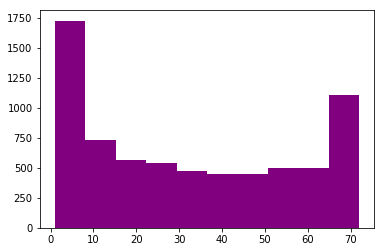

In [34]:
plt.hist(df.tenure, color='purple');

#### Correlation Heatmap <a id='corr_heatmap'></a>
<a href='#top'>Back to Top</a>

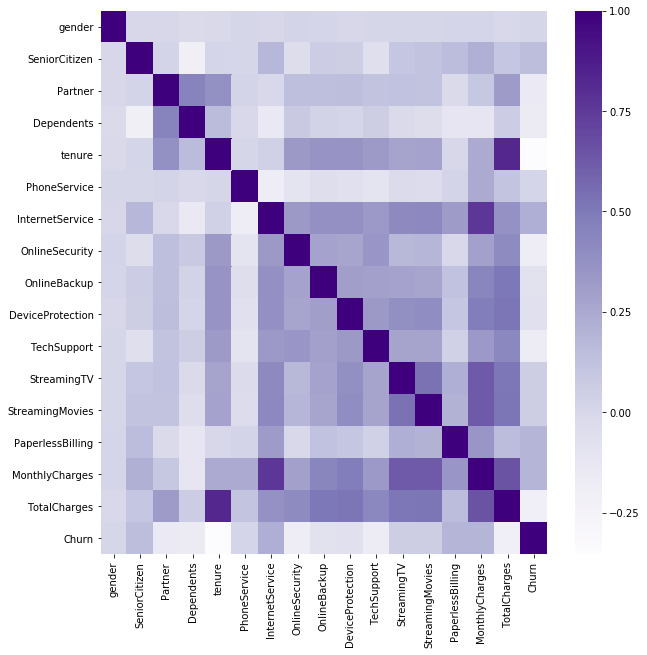

In [40]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap='Purples')

### Preprocess the Data <a id='section_3'></a>
<a href='#top'>Back to Top</a>

In [41]:
dummy_df = pd.get_dummies(df)
dummy_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Automatic,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,1,0,1,0,...,1,29.85,29.85,0,1,0,0,0,1,0
1,0,0,0,0,34,1,1,1,0,1,...,0,56.95,1889.50,0,0,1,0,0,0,1
2,0,0,0,0,2,1,1,1,1,0,...,1,53.85,108.15,1,1,0,0,0,0,1
3,0,0,0,0,45,0,1,1,0,1,...,0,42.30,1840.75,0,0,1,0,1,0,0
4,1,0,0,0,2,1,1,0,0,0,...,1,70.70,151.65,1,1,0,0,0,1,0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
gender              7032 non-null int64
SeniorCitizen       7032 non-null int64
Partner             7032 non-null int64
Dependents          7032 non-null int64
tenure              7032 non-null int64
PhoneService        7032 non-null int64
InternetService     7032 non-null int64
OnlineSecurity      7032 non-null int64
OnlineBackup        7032 non-null int64
DeviceProtection    7032 non-null int64
TechSupport         7032 non-null int64
StreamingTV         7032 non-null int64
StreamingMovies     7032 non-null int64
Contract            7032 non-null object
PaperlessBilling    7032 non-null int64
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null int64
dtypes: float64(2), int64(15), object(2)
memory usage: 1.1+ MB


In [42]:
y = dummy_df.Churn
X = dummy_df.drop('Churn', axis=1)

In [43]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [44]:
scaled_df = pd.DataFrame(scaled_X, index=X.index, columns=X.columns)

In [45]:
scaled_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Automatic,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.009430,-0.440327,1.035617,-0.652305,-1.280248,-3.056334,0.52513,-0.633746,1.378330,-0.723918,...,-0.796849,0.828939,-1.161694,-0.994194,0.902613,-0.514537,-0.561364,-0.878482,1.404764,-0.543604
1,-0.990658,-0.440327,-0.965608,-0.652305,0.064303,0.327189,0.52513,1.577918,-0.725516,1.381372,...,-0.796849,-1.206361,-0.260878,-0.173740,-1.107895,1.943495,-0.561364,-0.878482,-0.711863,1.839576
2,-0.990658,-0.440327,-0.965608,-0.652305,-1.239504,0.327189,0.52513,1.577918,1.378330,-0.723918,...,-0.796849,0.828939,-0.363923,-0.959649,0.902613,-0.514537,-0.561364,-0.878482,-0.711863,1.839576
3,-0.990658,-0.440327,-0.965608,-0.652305,0.512486,-3.056334,0.52513,1.577918,-0.725516,1.381372,...,-0.796849,-1.206361,-0.747850,-0.195248,-1.107895,1.943495,-0.561364,1.138327,-0.711863,-0.543604
4,1.009430,-0.440327,-0.965608,-0.652305,-1.239504,0.327189,0.52513,-0.633746,-0.725516,-0.723918,...,-0.796849,0.828939,0.196178,-0.940457,0.902613,-0.514537,-0.561364,-0.878482,1.404764,-0.543604


In [46]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, random_state=19)

### IV. Modeling <a id='section_4'></a>
<a href='#top'>Back to Top</a>

#### Decision Tree

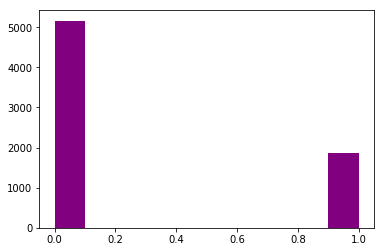

In [47]:
plt.hist(y, color='purple');

In [47]:
dt = DecisionTreeClassifier(random_state=19, class_weight='balanced')
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=19,
            splitter='best')

In [48]:
dt_train_preds = dt.predict(X_train)
dt_test_preds = dt.predict(X_test)

#### Print Metrics Function <a id='print_metrics'></a>
<a href='#top'>Back to Top</a>

In [49]:
def print_metrics(y_train, y_test, y_train_preds, y_test_preds):
    
    """Accepts train and test set predictions and prints evaluation metrics"""
    
    print('Train Set Classification Report')
    print(classification_report(y_train, y_train_preds))
    print('*'*50)
    print('Test Set Classification Report')
    print(classification_report(y_test, y_test_preds))
    print('*'*50)
    print('Train Set Confusion Matrix')
    print(confusion_matrix(y_train, y_train_preds))
    print('*'*50)
    print('Test Set Confusion Matrix')
    print(confusion_matrix(y_test, y_test_preds))
    print('*'*50)
    print('Train Set Accuracy Score')
    print(accuracy_score(y_train, y_train_preds))
    print('*'*50)
    print('Test Set Accuracy Score')
    print(accuracy_score(y_test, y_test_preds))

In [50]:
print_metrics(y_train, y_test, dt_train_preds, dt_test_preds)

Train Set Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3878
           1       0.99      1.00      1.00      1396

   micro avg       1.00      1.00      1.00      5274
   macro avg       1.00      1.00      1.00      5274
weighted avg       1.00      1.00      1.00      5274

**************************************************
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1285
           1       0.51      0.53      0.52       473

   micro avg       0.74      0.74      0.74      1758
   macro avg       0.67      0.67      0.67      1758
weighted avg       0.74      0.74      0.74      1758

**************************************************
Train Set Confusion Matrix
[[3870    8]
 [   0 1396]]
**************************************************
Test Set Confusion Matrix
[[1046  239]
 [ 224  249]]
***********************

#### Random Forest

In [51]:
rf = RandomForestClassifier(random_state=19, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False, random_state=19,
            verbose=0, warm_start=False)

In [52]:
rf_train_preds = rf.predict(X_train)
rf_test_preds = rf.predict(X_test)

In [53]:
print_metrics(y_train, y_test, rf_train_preds, rf_test_preds)

Train Set Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3878
           1       0.99      0.93      0.96      1396

   micro avg       0.98      0.98      0.98      5274
   macro avg       0.98      0.97      0.97      5274
weighted avg       0.98      0.98      0.98      5274

**************************************************
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.81      0.90      0.86      1285
           1       0.62      0.44      0.51       473

   micro avg       0.78      0.78      0.78      1758
   macro avg       0.72      0.67      0.68      1758
weighted avg       0.76      0.78      0.76      1758

**************************************************
Train Set Confusion Matrix
[[3866   12]
 [  93 1303]]
**************************************************
Test Set Confusion Matrix
[[1159  126]
 [ 266  207]]
***********************

#### Custom Prediction Function <a id='custom_predict'></a>
<a href='#top'>Back to Top</a>

In [54]:
def custom_predict(clf, X_test, thresh=0.35):
    
    """Accepts model, features, and threshold for predicting target labels. Returns custom predictions."""
    
    y_preds = clf.predict_proba(X_test)
    classes = []
    for pred in y_preds:
        if pred[1] >= thresh:
            classes.append(1)
        else:
            classes.append(0)
    return np.array(classes)

In [55]:
rf_custom_y_preds = custom_predict(rf, X_test)

In [56]:
print_metrics(y_train, y_test, rf_train_preds, rf_custom_y_preds)

Train Set Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3878
           1       0.99      0.93      0.96      1396

   micro avg       0.98      0.98      0.98      5274
   macro avg       0.98      0.97      0.97      5274
weighted avg       0.98      0.98      0.98      5274

**************************************************
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1285
           1       0.53      0.65      0.59       473

   micro avg       0.75      0.75      0.75      1758
   macro avg       0.70      0.72      0.71      1758
weighted avg       0.77      0.75      0.76      1758

**************************************************
Train Set Confusion Matrix
[[3866   12]
 [  93 1303]]
**************************************************
Test Set Confusion Matrix
[[1016  269]
 [ 165  308]]
***********************

#### Plot feature importance function <a id='plot_features'></a>
<a href='#top'>Back to Top</a>

In [57]:
def plot_feature_importances(model):
    
    """Visualize feature importance of selected model as determined by feature_importances_ method."""
    
    n_features = X_train.shape[1]
    plt.figure(figsize=(12,12))
    plt.barh(range(n_features), model.feature_importances_, align='center', color='purple') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")

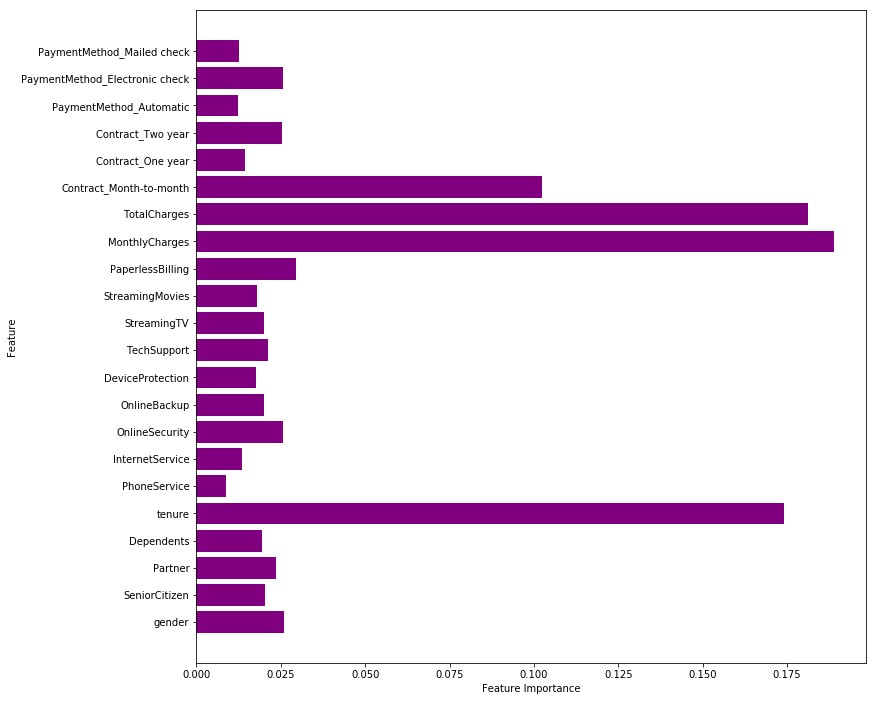

In [58]:
plot_feature_importances(rf)

### GridSearch - optimized for recall score <a id='gridsearch'></a>
<a href='#top'>Back to Top</a>

#### Random Forest GridSearch <a id='random_forest'></a>

In [74]:
rf_param_grid = {
    'n_estimators': [5, 10, 15, 20, 35, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [0.1, 0.2, 0.3, 0.4, 0.5],
    'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'min_impurity_decrease': [0, 0.1, 0.001, 0.0001, 0.00001]
}

num_perm = 6 * 2 * 4 * 5 * 5 * 3 * 5
print(f'GridSearch will search through {num_perm} different permutations.')

GridSearch will search through 18000 different permutations.


In [70]:
# import time

In [75]:
# start_time = time.time()

# rf_grid_search = GridSearchCV(rf, rf_param_grid, scoring='recall', cv=3)
# rf_grid_search.fit(scaled_df, y)

# print(f'Best Score: {rf_grid_search.best_score_ * 100}%')
# print(f'Total Runtime: {time.time() - start_time} seconds')
# print('')
# print(f'Optimal Parameters: {rf_grid_search.best_params_}')

Best Score: 91.22525414660247%
Total Runtime: 2019.1292400360107 seconds

Optimal Parameters: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 0.3, 'min_samples_split': 0.1, 'n_estimators': 5}


#### Results of Random Forest GridSearch
* class_weight: balanced_subsample
* criterion: entropy
* max_depth: None (Default)
* min_impurity_decrease: 0.1
* min_samples_leaf: 0.3
* min_samples_split: 0.1
* n_estimators: 5

In [59]:
optimized_rf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', random_state=19, \
                                     min_impurity_decrease=0.1, min_samples_leaf=0.3, min_samples_split=0.1, \
                                     n_estimators=5)
optimized_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.1,
            min_impurity_split=None, min_samples_leaf=0.3,
            min_samples_split=0.1, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=None, oob_score=False, random_state=19,
            verbose=0, warm_start=False)

In [60]:
op_rf_train_preds = optimized_rf.predict(X_train)
op_rf_test_preds = optimized_rf.predict(X_test)

In [61]:
print_metrics(y_train, y_test, op_rf_train_preds, op_rf_test_preds)

Train Set Classification Report
              precision    recall  f1-score   support

           0       0.86      0.60      0.71      3878
           1       0.40      0.74      0.52      1396

   micro avg       0.64      0.64      0.64      5274
   macro avg       0.63      0.67      0.61      5274
weighted avg       0.74      0.64      0.66      5274

**************************************************
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.87      0.61      0.71      1285
           1       0.41      0.75      0.53       473

   micro avg       0.64      0.64      0.64      1758
   macro avg       0.64      0.68      0.62      1758
weighted avg       0.74      0.64      0.66      1758

**************************************************
Train Set Confusion Matrix
[[2338 1540]
 [ 368 1028]]
**************************************************
Test Set Confusion Matrix
[[778 507]
 [119 354]]
***************************

#### Decision Tree GridSearch <a id='decision_tree'></a>
<a href='#top'>Back to Top</a>

In [82]:
dt = DecisionTreeClassifier(random_state=19)

In [83]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [0.1, 0.3, 0.5],
    'min_samples_leaf': [0.1, 0.3, 0.5],
    'class_weight': [None, 'balanced'],
    'min_impurity_decrease': [0, 0.1, 0.001]
}

num_perm = 2 * 3 * 3 * 3 * 2 * 3
print(f'GridSearch will search through {num_perm} different permutations.')

GridSearch will search through 324 different permutations.


In [84]:
# start_time = time.time()

# dt_grid_search = GridSearchCV(dt, dt_param_grid, scoring='recall', cv=3)
# dt_grid_search.fit(scaled_df, y)

# print(f'Best Score: {dt_grid_search.best_score_ * 100}%')
# print(f'Total Runtime: {time.time() - start_time} seconds')
# print('')
# print(f'Optimal Parameters: {dt_grid_search.best_params_}')

Best Score: 88.55002675227394%
Total Runtime: 6.125700950622559 seconds

Optimal Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 0.1, 'min_samples_split': 0.3}


#### Results of Decision Tree GridSearch
* class_weight: balanced
* criterion: gini (Default)
* max_depth: None (Default)
* min_impurity_decrease: 0 (Default)
* min_samples_leaf: 0.1
* min_samples_split: 0.3

In [62]:
optimized_dt = DecisionTreeClassifier(class_weight='balanced', random_state=19, min_samples_leaf=0.1, min_samples_split=0.3)
optimized_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=19,
            splitter='best')

In [63]:
op_dt_train_preds = optimized_dt.predict(X_train)
op_dt_test_preds = optimized_dt.predict(X_test)

In [64]:
print_metrics(y_train, y_test, op_dt_train_preds, op_dt_test_preds)

Train Set Classification Report
              precision    recall  f1-score   support

           0       0.93      0.57      0.70      3878
           1       0.42      0.88      0.57      1396

   micro avg       0.65      0.65      0.65      5274
   macro avg       0.67      0.72      0.64      5274
weighted avg       0.79      0.65      0.67      5274

**************************************************
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.95      0.58      0.72      1285
           1       0.44      0.91      0.60       473

   micro avg       0.67      0.67      0.67      1758
   macro avg       0.70      0.75      0.66      1758
weighted avg       0.81      0.67      0.69      1758

**************************************************
Train Set Confusion Matrix
[[2197 1681]
 [ 173 1223]]
**************************************************
Test Set Confusion Matrix
[[746 539]
 [ 41 432]]
***************************

In [65]:
print(f'Overall Test Recall Score: {recall_score(y_test, op_dt_test_preds)}')

Overall Test Recall Score: 0.9133192389006343


#### Vanilla AdaBoost 

In [89]:
ada = AdaBoostClassifier(random_state=19)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=19)

In [90]:
ada_train_preds = ada.predict(X_train)
ada_test_preds = ada.predict(X_test)

In [91]:
print_metrics(y_train, y_test, ada_train_preds, ada_test_preds)

Train Set Classification Report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3878
           1       0.65      0.53      0.59      1396

   micro avg       0.80      0.80      0.80      5274
   macro avg       0.75      0.71      0.73      5274
weighted avg       0.79      0.80      0.79      5274

**************************************************
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1285
           1       0.64      0.53      0.58       473

   micro avg       0.79      0.79      0.79      1758
   macro avg       0.74      0.71      0.72      1758
weighted avg       0.79      0.79      0.79      1758

**************************************************
Train Set Confusion Matrix
[[3487  391]
 [ 655  741]]
**************************************************
Test Set Confusion Matrix
[[1147  138]
 [ 223  250]]
***********************

#### AdaBoost GridSearch <a id='ada_boost'></a>
<a href='#top'>Back to Top</a>

In [93]:
ada_param_grid = {
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': [25, 50, 75],
    'learning_rate': [0.1, 0.3, 0.5, 1, 1.5],
}

num_perm = 2 * 3 * 5
print(f'GridSearch will search through {num_perm} permutations')

GridSearch will search through 30 permutations


In [94]:
# start_time = time.time()

# ada_grid_search = GridSearchCV(ada, ada_param_grid, scoring='recall', cv=3)
# ada_grid_search.fit(scaled_df, y)

# print(f'Best Score: {ada_grid_search.best_score_ * 100}%')
# print(f'Total Runtime: {time.time() - start_time} seconds')
# print('')
# print(f'Optimal Parameters: {ada_grid_search.best_params_}')

Best Score: 57.73140716960942%
Total Runtime: 12.828197002410889 seconds

Optimal Parameters: {'algorithm': 'SAMME', 'learning_rate': 1.5, 'n_estimators': 25}


#### Results of AdaBoost GridSearch
* algorithm: SAMME
* learning_rate: 1.5
* n_estimators: 25

In [66]:
optimized_ada = AdaBoostClassifier(algorithm='SAMME', learning_rate=1.5, n_estimators=25, random_state=19)
optimized_ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.5,
          n_estimators=25, random_state=19)

In [67]:
op_ada_train_preds = optimized_ada.predict(X_train)
op_ada_test_preds = optimized_ada.predict(X_test)

In [68]:
print_metrics(y_train, y_test, op_ada_train_preds, op_ada_test_preds)

Train Set Classification Report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3878
           1       0.66      0.50      0.57      1396

   micro avg       0.80      0.80      0.80      5274
   macro avg       0.75      0.70      0.72      5274
weighted avg       0.79      0.80      0.79      5274

**************************************************
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1285
           1       0.66      0.47      0.55       473

   micro avg       0.79      0.79      0.79      1758
   macro avg       0.74      0.69      0.71      1758
weighted avg       0.78      0.79      0.78      1758

**************************************************
Train Set Confusion Matrix
[[3525  353]
 [ 703  693]]
**************************************************
Test Set Confusion Matrix
[[1172  113]
 [ 249  224]]
***********************

#### Gradient Boosting

In [70]:
grab = GradientBoostingClassifier(random_state=19)
grab.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=19,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [99]:
grab_train_preds = grab.predict(X_train)
grab_test_preds = grab.predict(X_test)

In [100]:
print_metrics(y_train, y_test, grab_train_preds, grab_test_preds)

Train Set Classification Report
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      3878
           1       0.73      0.56      0.63      1396

   micro avg       0.83      0.83      0.83      5274
   macro avg       0.79      0.74      0.76      5274
weighted avg       0.82      0.83      0.82      5274

**************************************************
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1285
           1       0.66      0.51      0.57       473

   micro avg       0.80      0.80      0.80      1758
   macro avg       0.75      0.71      0.72      1758
weighted avg       0.79      0.80      0.79      1758

**************************************************
Train Set Confusion Matrix
[[3588  290]
 [ 613  783]]
**************************************************
Test Set Confusion Matrix
[[1162  123]
 [ 233  240]]
***********************

#### Gradient Boosting GridSearch <a id='gradient'></a>
<a href='#top'>Back to Top</a>

In [71]:
grab_param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [75, 100, 125],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_depth': [3, 4, 5],
}

In [72]:
grab_grid_search = GridSearchCV(grab, grab_param_grid, scoring='recall', cv=3, verbose=True)
grab_grid_search.fit(scaled_df, y)

print(f'Best Score: {grab_grid_search.best_score_ * 100}%')
print('')
print(f'Optimal Parameters: {grab_grid_search.best_params_}')

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed:  4.1min finished


Best Score: 53.29052969502407%

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


#### Results of Gradient Boosting GridSearch
* learning_rate: 0.1 (Default)
* max_depth: 4
* min_samples_leaf: 1 (Default)
* min_samples_split: 2 (Default)
* n_estimators: 100 (Default)

In [73]:
optimized_grab = GradientBoostingClassifier(max_depth=4, random_state=19)
optimized_grab.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=19,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [74]:
op_grab_train_preds = optimized_grab.predict(X_train)
op_grab_test_preds = optimized_grab.predict(X_test)

In [75]:
print_metrics(y_train, y_test, op_grab_train_preds, op_grab_test_preds)

Train Set Classification Report
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3878
           1       0.77      0.61      0.68      1396

   micro avg       0.85      0.85      0.85      5274
   macro avg       0.82      0.77      0.79      5274
weighted avg       0.84      0.85      0.84      5274

**************************************************
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1285
           1       0.65      0.50      0.56       473

   micro avg       0.79      0.79      0.79      1758
   macro avg       0.74      0.70      0.71      1758
weighted avg       0.78      0.79      0.78      1758

**************************************************
Train Set Confusion Matrix
[[3626  252]
 [ 547  849]]
**************************************************
Test Set Confusion Matrix
[[1157  128]
 [ 237  236]]
***********************

In [76]:
print(f'Recall Score for Gradient Boosting Test Set: {recall_score(y_test, op_grab_test_preds)}')

Recall Score for Gradient Boosting Test Set: 0.4989429175475687


### V. Conclusions & Recommendations <a id='section_5'></a>
<a href='#top'>Back to Top</a>

#### Best Model
The Decision Tree model optimized for recall score had the best test set recall at __91%__. The training and test scores were similar, indicating that there was little underfitting or overfitting. We chose to optimize our models for recall score due to the fact that missing a customer who will churn is more detrimental to the business than predicting a customer will churn, but actually stays with the business. 

## Stuff We Aren't Using

In [79]:
op_rf_custom_train_preds = custom_predict(optimized_rf, X_train)
op_rf_custom_test_preds = custom_predict(optimized_rf, X_test)

In [81]:
print_metrics(y_train, y_test, op_rf_custom_train_preds, op_rf_custom_test_preds)

Train Set Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3878
           1       0.26      1.00      0.42      1396

   micro avg       0.26      0.26      0.26      5274
   macro avg       0.13      0.50      0.21      5274
weighted avg       0.07      0.26      0.11      5274

**************************************************
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1285
           1       0.27      1.00      0.42       473

   micro avg       0.27      0.27      0.27      1758
   macro avg       0.13      0.50      0.21      1758
weighted avg       0.07      0.27      0.11      1758

**************************************************
Train Set Confusion Matrix
[[   0 3878]
 [   0 1396]]
**************************************************
Test Set Confusion Matrix
[[   0 1285]
 [   0  473]]
***********************

#### Gradient Boosting GridSearch

In [106]:
grab_param_grid = {
    'criterion': ['friedman_mse', 'mse', 'mae'],
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.1, 0.3, 0.5],
    'n_estimators': [75, 100, 125],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_depth': [3, 4, 5, 6],
    'min_impurity_decrease': [0, 0.1, 0.01],
    'max_features': [None, 'sqrt', 'log2']
}

num_perm = 3 * 2 * 3 * 3 * 2 * 3 * 4 * 3 * 3
print(f'GridSearch will search through {num_perm} different permutations.')

GridSearch will search through 11664 different permutations.


In [108]:
# GridSearch took 3+ hours with this many permutations, so kernel was interrupted

# start_time = time.time()

# grab_grid_search = GridSearchCV(grab, grab_param_grid, scoring='recall', cv=3)
# grab_grid_search.fit(scaled_df, y)

# print(f'Best Score: {grab_grid_search.best_score_ * 100}%')
# print(f'Total Runtime: {time.time() - start_time} seconds')
# print('')
# print(f'Optimal Parameters: {grab_grid_search.best_params_}')

### Optimizing for F1 Score

#### AdaBoost GridSearch

In [109]:
ada_param_grid = {
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': [25, 50, 75],
    'learning_rate': [0.1, 0.3, 0.5, 1, 1.5],
}

num_perm = 2 * 3 * 5
print(f'GridSearch will search through {num_perm} permutations')

GridSearch will search through 30 permutations


In [111]:
# start_time = time.time()

# ada_grid_search = GridSearchCV(ada, ada_param_grid, scoring=make_scorer(f1_score), cv=3, verbose=True)
# ada_grid_search.fit(scaled_df, y)

# print(f'Best Score: {ada_grid_search.best_score_ * 100}%')
# print(f'Total Runtime: {time.time() - start_time} seconds')
# print('')
# print(f'Optimal Parameters: {ada_grid_search.best_params_}')

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score: 59.92759584831195%
Total Runtime: 12.498500108718872 seconds

Optimal Parameters: {'algorithm': 'SAMME', 'learning_rate': 1.5, 'n_estimators': 25}


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   12.4s finished


#### Results of AdaBoost GridSearch
* algorithm: SAMME
* learning_rate: 1.5
* n_estimators: 25

In [112]:
optimized_ada = AdaBoostClassifier(random_state=19, algorithm='SAMME', learning_rate=1.5, n_estimators=25)
optimized_ada.fit(scaled_df, y)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.5,
          n_estimators=25, random_state=19)

In [113]:
op_ada_train_preds = optimized_ada.predict(X_train)
op_ada_test_preds = optimized_ada.predict(X_test)

In [114]:
print_metrics(y_train, y_test, op_ada_train_preds, op_ada_test_preds)

Train Set Classification Report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3878
           1       0.65      0.54      0.59      1396

   micro avg       0.80      0.80      0.80      5274
   macro avg       0.75      0.72      0.73      5274
weighted avg       0.79      0.80      0.80      5274

**************************************************
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1285
           1       0.66      0.53      0.59       473

   micro avg       0.80      0.80      0.80      1758
   macro avg       0.75      0.71      0.73      1758
weighted avg       0.79      0.80      0.79      1758

**************************************************
Train Set Confusion Matrix
[[3477  401]
 [ 643  753]]
**************************************************
Test Set Confusion Matrix
[[1155  130]
 [ 222  251]]
***********************

#### Decision Tree GridSearch - F1

In [124]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [0.1, 0.3, 0.5],
    'min_samples_leaf': [0.1, 0.3, 0.5],
    'class_weight': [None, 'balanced'],
    'min_impurity_decrease': [0, 0.1, 0.001]
}

In [125]:
# dt_grid_search = GridSearchCV(dt, dt_param_grid, scoring=make_scorer(f1_score), cv=3, verbose=True)
# dt_grid_search.fit(scaled_df, y)

# print(f'Best Score: {dt_grid_search.best_score_ * 100}%')
# print('')
# print(f'Optimal Parameters: {dt_grid_search.best_params_}')

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score: 60.72454198432071%

Optimal Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}


[Parallel(n_jobs=1)]: Done 972 out of 972 | elapsed:    6.1s finished


In [126]:
op_dt = DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0, min_samples_leaf=0.1, min_samples_split=0.1, random_state=19)
op_dt.fit(scaled_df, y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=19,
            splitter='best')

In [127]:
op_dt_train_preds = op_dt.predict(X_train)
op_dt_test_preds = op_dt.predict(X_test)

In [128]:
print_metrics(y_train, y_test, op_dt_train_preds, op_dt_test_preds)

Train Set Classification Report
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      3878
           1       0.49      0.79      0.61      1396

   micro avg       0.73      0.73      0.73      5274
   macro avg       0.70      0.75      0.70      5274
weighted avg       0.79      0.73      0.75      5274

**************************************************
Test Set Classification Report
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1285
           1       0.51      0.81      0.63       473

   micro avg       0.74      0.74      0.74      1758
   macro avg       0.71      0.77      0.72      1758
weighted avg       0.81      0.74      0.76      1758

**************************************************
Train Set Confusion Matrix
[[2759 1119]
 [ 300 1096]]
**************************************************
Test Set Confusion Matrix
[[922 363]
 [ 88 385]]
***************************